<center><font size="6.9"><b>Python进行零售商品数据分析</b></font></center>

本次零售超市报告分析主要内容如下：  
1、清洗数据。将列名统一修改、处理缺失数据和异常数据、转换日期等数据类型  
2、查看总体销售情况  
3、商品维度进行分析。主要分析内容有：商品价格分析，商品销售量、销售额情况分析，商品关联分析  
4、店铺维度进行分析。主要分析内容有：店铺销售量、销售额法分析，店铺促销情况分析，店铺销售时间分析，周均消费次数分析，客单价分析等  
5、相关性分析：用关联关系表、相关矩阵图和密度图初步对变量之间的关系进行分析。  
6、用户维度进行分析。主要分析内容有：分析用户基本购买情况，按时间（周）对用户购买情况进行分析，用户购买力分析，用户消费时间节点分析，用户复购率分析，用户RFM区分用户


## **一、导入所需的包**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#实现关联规则所需的包
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

## **二、导入数据**

In [3]:
#导入basket数据、简单查看数据
basket = pd.read_csv("Basket-2018-06-01-2018-07-05.csv")
basket.head()

,SHOP_DATETIME,STORE_CODE,POS_NO,BASK_CODE,BASK_SPEND
0,2018-06-01,D007,3,250458,8.0
1,2018-06-01,D007,3,250200,32.7
2,2018-06-01,D007,1,161068,16.8
3,2018-06-01,D007,8,5325,30.4
4,2018-06-01,D007,8,5361,191.3


In [4]:
#导入item数据、简单查看数据
item = pd.read_csv("item-2018-06-01-2018-07-05.csv")
item.head()

,SDATE,STORE_CODE,POSID,BASK_CODE,PROD_CODE,ITEM_QUANTITY,ITEM_SPEND,NORMAL_PRICE,DISCOUNT_TYPE,DISCOUNT_AMOUNT
0,2018-06-01,D007,3,250451,29405,1.000,1.70,2.0,m,-0.3
1,2018-06-01,D007,3,250451,13187,1.000,1.00,1.0,n,0.0
2,2018-06-01,D007,3,250243,196249,1.000,99.00,99.0,m,0.0
3,2018-06-01,D007,3,250243,199637,1.000,9.90,16.8,p,-6.9
4,2018-06-01,D007,1,160905,195012,3.222,18.69,5.8,n,0.0


本文数据集为真实零售超市的真实数据，该数据集包含2018年6月1日-2018年7月5日的公司网上零售的交易信息。本小节简单展示了basket和item数据集，basket数据表字段包括：SHOP_DATETIME（订单日期）、STORE_CODE（商店编号）、POS_NO（POS机编号、BASK_CODE（订单编号）、BASK_SPEND（订单金额）；item数据集字段包括：SDATE（订单日期）、STORE_CODE（商店编号）、POSID（POS机编号）、BASK_CODE（订单编号）、PROD_CODE（商品编号）、ITEM_QUANTITY（商品数量）、ITEM_SPEND（商品实际价格）、NORMAL_PRICE（商品单价）、DISCOUNT_TYPE（折扣类型）、DISCOUNT_AMOUNT（折扣金额）

## **三、数据查看与清洗**

### **1、查看数据特征**

In [5]:
#查看basket数据总体特征
basket.info()
basket.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 571552 entries, 0 to 571551
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   SHOP_DATETIME  571552 non-null  object 
 1   STORE_CODE     571552 non-null  object 
 2   POS_NO         571552 non-null  int64  
 3   BASK_CODE      571552 non-null  int64  
 4   BASK_SPEND     571552 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 21.8+ MB


,POS_NO,BASK_CODE,BASK_SPEND
count,571552.000000,571552.000000,571552.000000
mean,2.998429,167472.817102,38.973310
std,2.516065,87263.199857,209.038276
min,1.000000,961.000000,-35940.000000
25%,1.000000,90533.750000,9.000000
50%,2.000000,177603.500000,19.900000
75%,3.000000,238816.750000,44.700000
max,20.000000,323914.000000,79920.000000


In [6]:
#查看item数据总体特征
item.info()
item.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1732761 entries, 0 to 1732760
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   SDATE            object 
 1   STORE_CODE       object 
 2   POSID            int64  
 3   BASK_CODE        int64  
 4   PROD_CODE        int64  
 5   ITEM_QUANTITY    float64
 6   ITEM_SPEND       float64
 7   NORMAL_PRICE     float64
 8   DISCOUNT_TYPE    object 
 9   DISCOUNT_AMOUNT  float64
dtypes: float64(4), int64(3), object(3)
memory usage: 132.2+ MB


,POSID,BASK_CODE,PROD_CODE,ITEM_QUANTITY,ITEM_SPEND,NORMAL_PRICE,DISCOUNT_AMOUNT
count,1.732761e+06,1.732761e+06,1.732761e+06,1.732761e+06,1.732761e+06,1.732761e+06,1.732761e+06
mean,2.994959e+00,1.659824e+05,1.144861e+05,1.436702e+00,1.285536e+01,1.424412e+01,-1.624232e+00
std,2.470286e+00,8.583102e+04,8.161988e+04,7.015504e+00,1.022148e+02,2.403937e+01,5.160490e+01
min,1.000000e+00,9.610000e+02,1.900000e+01,-6.000000e+02,-3.594000e+04,5.000000e-01,-5.760000e+04
25%,1.000000e+00,8.995200e+04,2.183500e+04,1.000000e+00,3.800000e+00,3.800000e+00,-1.000000e+00
50%,2.000000e+00,1.758280e+05,1.233210e+05,1.000000e+00,7.000000e+00,7.800000e+00,0.000000e+00
75%,3.000000e+00,2.229530e+05,1.959930e+05,1.000000e+00,1.200000e+01,1.500000e+01,0.000000e+00
max,2.000000e+01,3.239140e+05,2.250470e+05,4.020000e+03,6.912000e+04,1.980000e+03,9.300000e+02


从图片中初步可以看出数据集可能存在的异常数据以及需要进行初步处理的地方有以下几点：  
1)两个数据表中的SDATE字段均需要做数据类型转换；  
2)Basket表中的BASK_SPEND字段有负值，即订单金额为负；  
3)item表中的ITEM_SPEND字段有负值，即商品实付金额为负；  
4)item表中的ITEM_QUANTITY字段有负值，即商品数量为负；  
5)item表中的DISCOUNT_AMOUTN字段数据有正值，即折扣后金额比折扣前金额高。

### **2、修改列名**

In [7]:
#为方便阅读与查看，将列名统一改为符合驼峰命名法
basket.columns = ['shop_date','store_id','pos_id','bask_id','bask_spend']
item.columns = ['shop_date','store_id','pos_id','bask_id','prod_id','item_quantity','item_spend','normal_price','discount_type','discount_amount']

### **3、缺失数据**

In [8]:
item.apply(lambda x: sum(x.isnull()) / len(x), axis=0)

shop_date          0.0
store_id           0.0
pos_id             0.0
bask_id            0.0
prod_id            0.0
item_quantity      0.0
item_spend         0.0
normal_price       0.0
discount_type      0.0
discount_amount    0.0
dtype: float64

In [9]:
basket.apply(lambda x: sum(x.isnull()) / len(x), axis=0)

shop_date     0.0
store_id      0.0
pos_id        0.0
bask_id       0.0
bask_spend    0.0
dtype: float64

数据不存在缺失情况，不需要对缺失数据进行填充。

### **4、查看并转换数据类型**

**(1)查看数据表数据类型**

In [10]:
print('-----------item-----------')
print(item.dtypes)

-----------item-----------
shop_date           object
store_id            object
pos_id               int64
bask_id              int64
prod_id              int64
item_quantity      float64
item_spend         float64
normal_price       float64
discount_type       object
discount_amount    float64
dtype: object


In [11]:
print('---------basket---------')
print(basket.dtypes)

---------basket---------
shop_date      object
store_id       object
pos_id          int64
bask_id         int64
bask_spend    float64
dtype: object


**(2)转换数据类型**

数据类型中的object表示如果一列中含有多个类型,则该列的类型会是object,同样字符串类型的列也会被当成object类型，因此数据类型中object类型需要调整。此外为方便计算，涉及编号的数据类型应为String类型，SDATE数据类型应为日期类型，数值类型由于涉及零售的金钱问题，也应都调整为两位小数。  
1)调整编号数据类型  
2)调整日期数据类型  
3)将金钱调整为两位小数  
4)调整后数据类型

In [12]:
#编号数据类型
item["store_id"] = item["store_id"].astype(str)
item["pos_id"] = item["pos_id"].astype(str)
item["bask_id"] = item["bask_id"].astype(str)
item["prod_id"] = item["prod_id"].astype(str)
basket["store_id"] = basket["store_id"].astype(str)
basket["pos_id"] = basket["pos_id"].astype(str)
basket["bask_id"] = basket["bask_id"].astype(str)

In [13]:
#日期数据类型
item.shop_date = pd.to_datetime(item.shop_date)
basket.shop_date = pd.to_datetime(basket.shop_date)

In [14]:
#金钱保留两位小数
pd.set_option('display.float_format', lambda x: '%.2f' % x)#将所有数据转换为两位小数

**(3)查看修改后数据表数据类型**

In [15]:
print('-----------item-----------')
print(item.dtypes)
print('---------basket---------')
print(basket.dtypes)

-----------item-----------
shop_date          datetime64[ns]
store_id                   object
pos_id                     object
bask_id                    object
prod_id                    object
item_quantity             float64
item_spend                float64
normal_price              float64
discount_type              object
discount_amount           float64
dtype: object
---------basket---------
shop_date     datetime64[ns]
store_id              object
pos_id                object
bask_id               object
bask_spend           float64
dtype: object


### **5、查看异常值并删除**

根据上一小节对数据的初步查看发现的问题进行操作，在上一小节中发现数据表中商品数量、订单总金额、商品实付金额均有负值，且折扣金额为正，折扣金额的计算可能受到金额为负的影响，此外，数据也可能存在空值。因此，异常值的删除主要有以下几个操作：  
1)将商品数量、订单总金额、商品实付金额为负值的调整为正值；  
2)新建销售总金额字段：销售总金额=单价*数量  
根据修改后的数据进行折扣金额的计算：折扣金额=销售总金额-实际付款金额（ITEM_SPEND），与实际折扣金额不同的可以判定为异常数据，进行删除操作；  
3)删除过后分析是否还存在折扣金额为正的数据，若存在，也进行删除操作。

In [16]:
#将商品数量ITEM_QUANTITY为负的改为正值
item[item.item_quantity < 0]
item['item_quantity'] = np.where(item['item_quantity'] < 0, -(item['item_quantity']), (item['item_quantity']))
#将表中实际支付为负的改为正值
item[item.item_spend < 0]
item['item_spend'] = np.where(item['item_spend'] < 0, -(item['item_spend']), (item['item_spend']))
#计算应付金额并改为小数点两位
item['item_spend_new'] = item['item_quantity']*item['normal_price']
item = item.round({'item_spend_new': 2})
#计算折扣并减去现有数据
item['discount_new'] = item['item_spend']-item['item_spend_new']         #新计算折扣
item['discount_differ']=item['discount_new']-item['discount_amount']     #新计算折扣-数据的折扣
item = item.round({'discount_differ': 2})
#删除折扣值不一样的值（使用drop方法可以删除行数据或列数据）
#item_new=item.loc[(item['discount_differ'] != 0)]   将折扣有问题的提取出来
item.drop(index=item[item.discount_differ != 0].index,inplace=True)

In [17]:
#查看删除异常值后的结果
item[(item['discount_differ'] != 0)]

,shop_date,store_id,pos_id,bask_id,prod_id,item_quantity,item_spend,normal_price,discount_type,discount_amount,item_spend_new,discount_new,discount_differ


In [18]:
#删除折扣金额为正的值
item[item.discount_amount > 0]
#删除（使用drop方法可以删除行数据或列数据）
item.drop(index=item[item.discount_amount > 0].index,inplace=True)
#检查下是否已删除
item[item.discount_amount > 0]

,shop_date,store_id,pos_id,bask_id,prod_id,item_quantity,item_spend,normal_price,discount_type,discount_amount,item_spend_new,discount_new,discount_differ


最后发现不存在折扣金额与实际折扣不同的数据，可以判定无异常值。 

In [19]:
#删除不需要的列
item.drop(item.columns[[10,11,12]], axis=1, inplace=True) 

## **三、数据分析**

### **1、总体销量数据**

In [22]:
print("---------总体销量数据---------")
print("总订单数",item['bask_id'].unique().size)
print("总销售额",item.item_spend.sum())
print("有流水的商品数",item.prod_id.unique().size)

---------总体销量数据---------
总订单数 280878
总销售额 22216624.170000013
有流水的商品数 19261


由总体销售情况分析可知，商店在2018年6月1日-2018年7月5日总订单数有280878单，总销售额为22216624.17元，有流水的商品数共19261个。

### **2、商品(productId)维度分析**

**（1）商品价格分析**

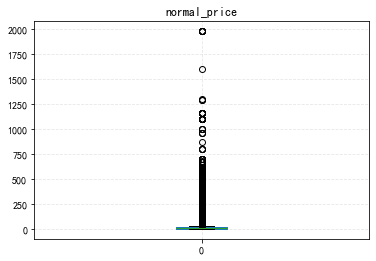

In [23]:
#商品价格箱型图分析
normal_price_array = np.array(item['normal_price'])
 
df = pd.DataFrame(normal_price_array)
df.plot.box(title="normal_price")
plt.grid(linestyle="--", alpha=0.3)
plt.show()

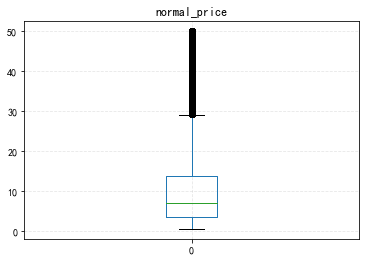

In [24]:
#商品价格0-50价格箱型图分析
item_normal=item.loc[(item['normal_price']<=50)]

normal_price_array = np.array(item_normal['normal_price'])
df = pd.DataFrame(normal_price_array)
df.plot.box(title="normal_price")
plt.grid(linestyle="--", alpha=0.3)
plt.show()

In [25]:
#求商品价格的四分位数
df_1 = pd.to_numeric(item_normal['normal_price'])
q = [df_1.quantile(i) for i in [0,.25,.5,.75,1]];q[-1] += 1
q

[0.5, 3.6, 7.0, 13.8, 51.0]

由最后的箱型图可知，商品价格最多的在3.6元~13.8元之间，也符合消费者在零售商店购买的商品价格会比较低，店家可以根据消费者的消费情况对商品进行调整，多上架一些平价、常用的商品供消费者选择

由于商品销售量最后的销售量为1，数量共2673个，因此查看销售量最后2673个商品中同时销售额在后10的商品，发现销售额最后的商品均为销量为1的商品，查看了商品销量和销售额之后，就可以查看销量和销售额都排名靠后的商品是哪些，找出之后再看具体是哪些商品，找出原因，考虑如何优化或者是否要下架。

**（2）查看销量排名前十和最后的商品**

In [26]:
prod_order_count = item.groupby("prod_id").count().sort_values(["bask_id"],ascending=False).bask_id
print("商品销量前十的prodId及销量")
prod_top_10 = prod_order_count.head(10)
print(prod_top_10)
dict_prod_count = {'prod_id':prod_order_count.index,'Count':prod_order_count.values}
df_prod_count = pd.DataFrame(dict_prod_count)
df_prod_tail=df_prod_count.loc[(df_prod_count['Count']==1)]
print('商品销量最后的prod_id及销量')
print(df_prod_tail['Count'])

商品销量前十的prodId及销量
prod_id
205540    12622
21835     10420
194690     9467
72811      7732
178462     7373
197532     7289
205437     6722
1557       6038
109584     5932
216571     5674
Name: bask_id, dtype: int64
商品销量最后的prod_id及销量
16588    1
16589    1
16590    1
16591    1
16592    1
        ..
19256    1
19257    1
19258    1
19259    1
19260    1
Name: Count, Length: 2673, dtype: int64


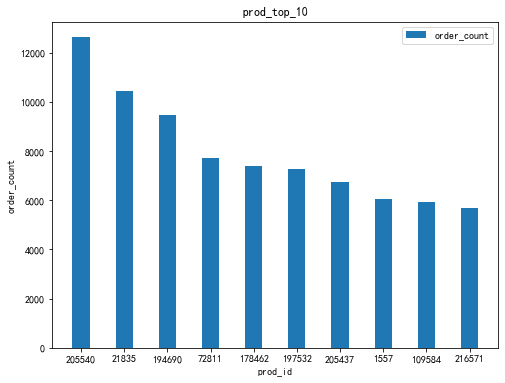

In [27]:
plt.figure(figsize=(8, 6))
N = 10
index=[1,2,3,4,5,6,7,8,9,10]
values=prod_top_10.values.tolist()
width = 0.4
p2 = plt.bar(index, values, width, label="order_count")
plt.xlabel('prod_id')
plt.ylabel('order_count')
plt.title('prod_top_10')
plt.xticks(index, ('205540','21835','194690','72811','178462','197532','205437','1557','109584','216571')) 
plt.legend(loc="upper right") 
plt.show()

本小节分析了商品销售量前10和商品销售量最后的商品数量，此外将商品销售量前10的商品绘制柱状图进行分析。由图表可知，前3销售量的商品很明显比后面商品销量多，差别至少为2000以上，而商品销量最后的商品在计算过程中发现有很多商品销量为1，将所有销量为1的商品提取出来，共有2673个，这2673个商品在这一段时间只销售了1个商品，可能为商品为不常用商品，也可能是商品本身有其他问题。

**（3）查看销售额排名前十和后十的商品**

In [28]:
prod_payMoney_amount = item.groupby("prod_id").sum().sort_values(["item_spend"],ascending=False).item_spend
prod_payMoney_top_10 = prod_payMoney_amount.head(10)
prod_payMoney_tail_10 = prod_payMoney_amount.tail(10)
print("商品销售额前十的prod_id及销售额")
print(prod_payMoney_top_10)
print("商品销售额后十的prod_id及销售额")
print(prod_payMoney_tail_10)

商品销售额前十的prod_id及销售额
prod_id
136839   281461.40
212574   257989.30
7137     248784.00
7133     197177.00
149413   173937.93
154900   141314.70
220834   127732.90
21835    113998.81
88160    103467.20
1239      96640.00
Name: item_spend, dtype: float64
商品销售额后十的prod_id及销售额
prod_id
179005   1.20
56482    1.15
10948    1.00
213291   1.00
146536   1.00
24925    0.82
156573   0.80
156643   0.80
2628     0.50
5588     0.50
Name: item_spend, dtype: float64


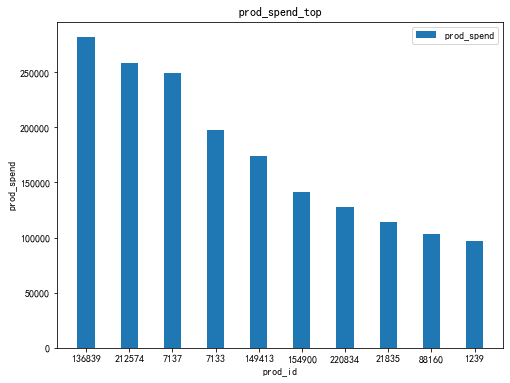

In [29]:
plt.figure(figsize=(8, 6))
N = 10
index=[1,2,3,4,5,6,7,8,9,10]
values=prod_payMoney_top_10 .values.tolist()
width = 0.4
p2 = plt.bar(index, values, width, label="prod_spend")
plt.xlabel('prod_id')
plt.ylabel('prod_spend')
plt.title('prod_spend_top')
plt.xticks(index, ('136839','212574','7137','7133','149413','154900','220834','21835','88160','1239')) 
plt.legend(loc="upper right") 
plt.show()

本小节主要分析了商品销售额前10和商品销售量后10的商品，此外将商品销售量前10的商品绘制柱状图进行分析。由图表可知，前3销售量的商品很明显比后面商品销售额多，差别至少为50000以上，而商品销量最后的商品仅仅在1元左右，这些商品无论是数量还是销售额都很少，商品可能存在问题。

**（4）查看销售量与销售额关系**

In [30]:
#intersection方法可以查看交集
problem_prod_id = prod_order_count.tail(2673).index.intersection(prod_payMoney_amount.tail(10).index)
print("销量与销售额共同分析")
print(problem_prod_id.values)

销量与销售额共同分析
['179005' '10948' '156573' '156643' '146536' '24925' '2628' '56482' '5588'
 '213291']


**（5）商品关联度分析**

In [22]:
item_new = item[['bask_id', 'prod_id']]

In [37]:
# 关联规则中不考虑多次购买同一件物品，删除重复数据
data = item_new.drop_duplicates()

# 初始化列表
data_set = []

# 分组聚合，同一用户购买多种商品的合并为一条数据，只有1件商品的没有意义，需要进行过滤
groups = item_new.groupby(by='bask_id')
for group in groups:
    if len(group[1]) >= 2:
        data_set.append(group[1]['prod_id'].tolist())

te = TransactionEncoder()
te_ary = te.fit(data_set).transform(data_set)
df = pd.DataFrame(te_ary, columns=te.columns_)

In [65]:
frequent_itemsets = apriori(df, min_support=0.005, use_colnames=True)

In [70]:
rules = association_rules(frequent_itemsets, min_threshold=0.4)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(124555),(125140),0.01,0.01,0.01,0.44,29.79,0.00,1.77
1,(124557),(124556),0.01,0.02,0.01,0.46,26.68,0.00,1.81
2,(124556),(125140),0.02,0.01,0.01,0.42,28.06,0.01,1.69
3,(125140),(124556),0.01,0.02,0.01,0.48,28.06,0.01,1.89
4,(4190),(124556),0.01,0.02,0.01,0.45,26.00,0.01,1.77
5,(4190),(125140),0.01,0.01,0.01,0.43,29.02,0.01,1.73
6,(1570),(1557),0.01,0.02,0.01,0.70,31.13,0.01,3.31


从以上的结果可以总结出：  
从总体上看，所有组合商品中支持度数值偏低，这是由于平台销售的商品种类繁多，也可能是用户同时购买两个商品的可能性低，需要进一步进行分析；  
商品组合[1570] --> [1557]的置信度最高，表示支持率在1%的情况下购买商品编号1570的用户中有70%会购买商品编号1557，可以对这两种商品进行捆绑销售；

### **3、店铺维度分析**

进行店铺维度的分析可以分析各店铺销售情况，判断哪些店铺销售情况不好，考虑是否需要对店铺员工进行培训或裁员。

**（1）店铺销售量情况分析**

In [38]:
# 1）找出销售数量前十的店
quan=item.groupby("store_id").count().sort_values(["prod_id"],ascending=False).prod_id
quan_top_10 = quan.head(10)
print("销售数量前10的店铺")
print(quan_top_10)

销售数量前10的店铺
store_id
D002    242040
A001    193274
D007    117528
A008    105930
A013     81355
A006     77677
D004     76497
D006     69905
A012     63716
A021     62853
Name: prod_id, dtype: int64


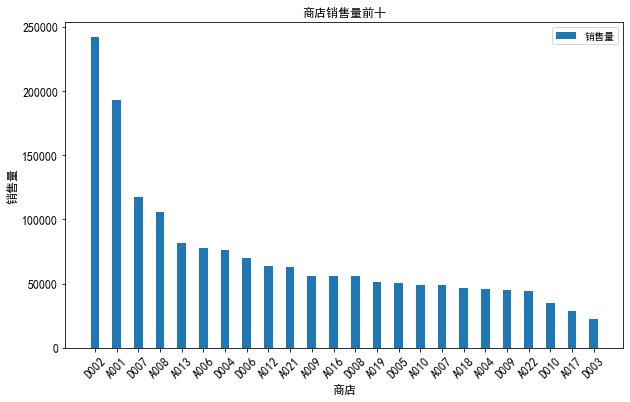

In [50]:
plt.figure(figsize=(10,6))
x=quan.index.tolist()
y=quan.values.tolist()
width = 0.4
p2 = plt.bar(x, y, width, label="销售量")
plt.xlabel('商店',fontsize=12)
plt.ylabel('销售量',fontsize=12)
plt.title('商店销售量比较图',fontsize=12) 
plt.legend(loc="upper right") 
plt.xticks(fontsize=12,rotation=45)
plt.yticks(fontsize=12)
plt.show()

本小节分析了商品销售量前10的店铺，可以发现商品销售数量前2的店铺销售量远超过后面的店铺，超过150000个商品，说明D002和A001两个店铺商品数量销售情况很好。

In [55]:
# 2）找出交易额前十的商店
price =  item[item["item_spend"] > 0].groupby("store_id")["item_spend"].sum().sort_values(ascending=False)
price_top_10 = price.head(10)
print("---交易额前10的店---")
print(price_top_10)

---交易额前10的店---
store_id
A001   3300089.92
D002   3174086.58
D007   1378684.27
A008   1333823.32
A013   1079565.25
A006    910200.17
A012    860496.50
D004    820932.46
A009    811515.73
D006    804117.71
Name: item_spend, dtype: float64


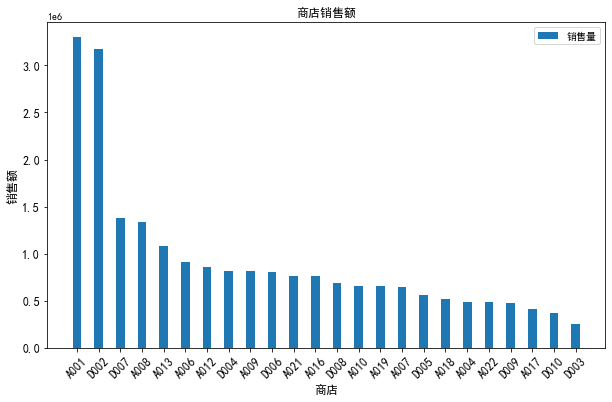

In [59]:
plt.figure(figsize=(10,6))
x=price.index.tolist()
y=price.values.tolist()
width = 0.4
p2 = plt.bar(x, y, width, label="销售量")
plt.xlabel('商店',fontsize=12)
plt.ylabel('销售额',fontsize=12)
plt.title('商店销售额',fontsize=12) 
plt.xticks(fontsize=12,rotation=45)
plt.yticks(fontsize=12)
plt.legend(loc="upper right") 
plt.show()

本小节分析了商品销售额前10的店铺，进行图表分析，可以发现A001和D002两个店铺销售额远超其他店铺，至少超过了2000000元，根据上小节分析，这两个店铺销售量与销售额均远超其他店铺，说明两个店铺销售情况良好。

**（2）店铺促销情况分析**

In [25]:
discount_storeid = item.groupby(by="store_id")["discount_amount"].sum().sort_values(ascending=True)
discount_storeid.head(10)

store_id
D002   -467277.67
A001   -452816.43
D007   -215143.94
A008   -138888.42
A013   -136626.64
A012   -116978.08
A006   -116201.95
D004   -110090.36
D008    -90884.61
D006    -85849.05
Name: discount_amount, dtype: float64

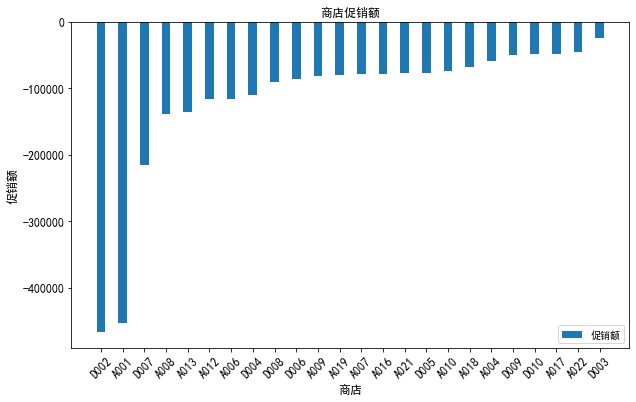

In [26]:
plt.figure(figsize=(10,6))
x=discount_storeid.index.tolist()
y=discount_storeid.values.tolist()
width = 0.4
p2 = plt.bar(x, y, width, label="促销额")
plt.xlabel('商店',fontsize=12)
plt.ylabel('促销额',fontsize=12)
plt.title('商店促销额',fontsize=12) 
plt.xticks(fontsize=12,rotation=45)
plt.yticks(fontsize=12)
plt.legend(loc="lower right") 
plt.show()

### **4、销售情况分析**

**（1）下单时间分析**

Text(0.5, 1.0, '每周下单分布')

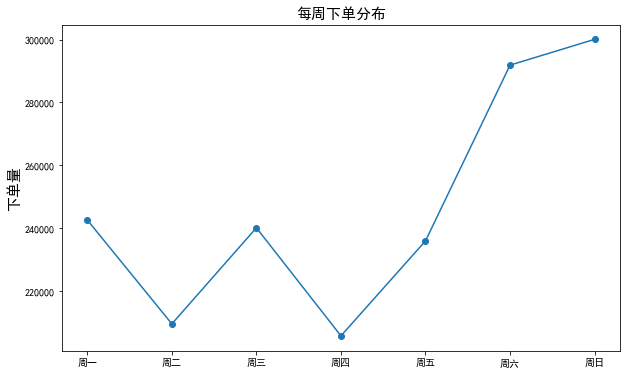

In [32]:
#增加"orderWeek"字段，记录星期几下单
item["order_week"] = item.shop_date.dt.dayofweek
#分组计算每周下单数
order_week_count = item.groupby("order_week").count().bask_id
#绘制折线图
plt.figure(figsize=(10,6))
plt.plot(order_week_count,marker="o")
xticks_labels = ["周一","周二","周三","周四","周五","周六","周日"]
plt.xticks(range(7),xticks_labels)
plt.ylabel("下单量",fontsize=15)
plt.title("每周下单分布",fontsize=15)

**（2）销售额分析**

Text(0.5, 1.0, '每周销售额分布')

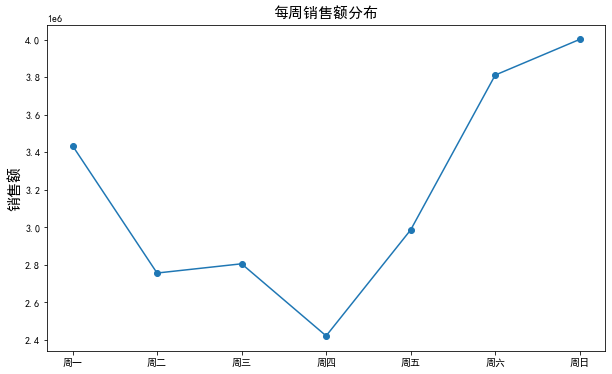

In [33]:
#分组计算每周销售额
order_week_count = item.groupby("order_week").sum().item_spend
#绘制折线图
plt.figure(figsize=(10,6))
plt.plot(order_week_count,marker="o")
xticks_labels = ["周一","周二","周三","周四","周五","周六","周日"]
plt.xticks(range(7),xticks_labels)
plt.ylabel("销售额",fontsize=15)
plt.title("每周销售额分布",fontsize=15)

由于数据表中时间仅有日期，没有具体的销售时间，且数据量由2018年6月1日-2018年7月5日，仅有约一个月的时间，因此分析月销售量没有很大的意义，因此首先对每周周一至周日的销售情况进行分组计算，求出一周内不同天的销售情况，分析每周哪一天销售情况最好。  
由图表可以看出，周一至周五的下单量在一条线上下波动，没有很大的起伏，周六和周日两天的下单量远远高于周一至周五的下单量，高出了至少50000单，销售额也是同样的趋势，超出了至少400000元，可以看出一般周末用户的下单量与交易额会远远高于工作日的下单情况，商家可以考虑在周末多上一些商品供用户选择。

**（3）每日销售额/销售量分析**

In [34]:
#分组计算每日销售额与销售量
item_spend_date = item.groupby("shop_date").sum().item_spend
item_num_date = item.groupby("shop_date").sum().item_quantity
labels = item['shop_date'].unique()

Text(0.5, 1.0, '日销售量分析')

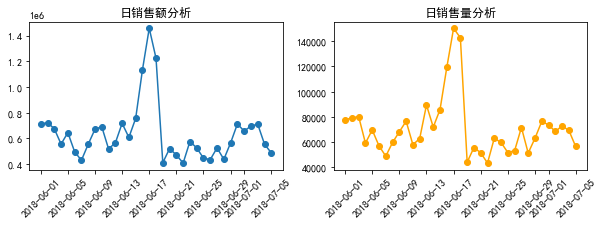

In [35]:
#分别绘制每日销售额、销售量折线图
#设置画布大小
plt.figure(figsize=(10,6))

plt.subplot(2,2,1)
plt.plot(item_spend_date,marker="o")
plt.xticks(rotation=45)
plt.title("日销售额分析")

plt.subplot(2,2,2)
plt.plot(item_num_date,marker="o",color='orange')
plt.xticks(rotation=45)
plt.title("日销售量分析")

Text(0.5, 1.0, '日销售额/销售量对比分析')

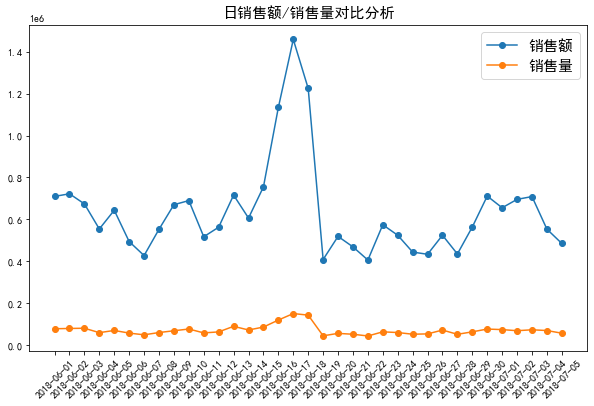

In [36]:
#绘制日销售额/销售量对比绘制折线图
plt.figure(figsize=(10,6))
plt.plot(item_spend_date,marker="o")
plt.plot(item_num_date,marker="o")
plt.legend(['销售额','销售量'],loc='upper right',fontsize=15)
plt.xticks(labels,rotation=45)
plt.title("日销售额/销售量对比分析",fontsize=15)

本小节分组计算了日销售额与日销售量的数据，并绘制了折线图进行趋势对比分析，由图中可知，销售量与销售额的趋势几乎相同，且均在2018年6月16日达到最高。

**（4）周均消费次数/金额**

In [37]:
#1周均消费次数=总消费次数/周数
bask_count = item.groupby('bask_id').count().shape[0]
week_count = item.loc[:,"order_week"].max()
print("总订单数",bask_count,'次')
print("周数",week_count,'周')
print("周均消费次数",bask_count//week_count,'次')

总订单数 280878 次
周数 6 周
周均消费次数 46813 次


In [38]:
#周均消费金额
price_sum = item.loc[:,'item_spend'].sum()
week_price = price_sum//week_count
print('周均消费金额为：',week_price,'元')

周均消费金额为： 3702770.0 元


**（5）客单价**

In [39]:
price_num = price_sum//bask_count
print('客单价为：',price_num,'元')

客单价为： 79.0 元


由于数据表中数据量由2018年6月1日-2018年7月5日，仅有约一个月的时间，因此分析月销售量没有很大的意义，因此首先对每周周一至周日的销售情况进行分组计算，求出不同周的大致销售情况，最终结果可知总订单数为280878次，共有6周的数据，周均消费次数为46813次

### **5、相关性分析**

**（1）查看数据相关性**

In [40]:
#关联关系
print(item.corr(method='pearson'))   #协方差矩阵

                 item_quantity  item_spend  normal_price  discount_amount  \
item_quantity             1.00        0.38         -0.04            -0.18   
item_spend                0.38        1.00          0.22            -0.74   
normal_price             -0.04        0.22          1.00            -0.09   
discount_amount          -0.18       -0.74         -0.09             1.00   
order_week               -0.00       -0.00          0.01            -0.00   

                 order_week  
item_quantity         -0.00  
item_spend            -0.00  
normal_price           0.01  
discount_amount       -0.00  
order_week             1.00  


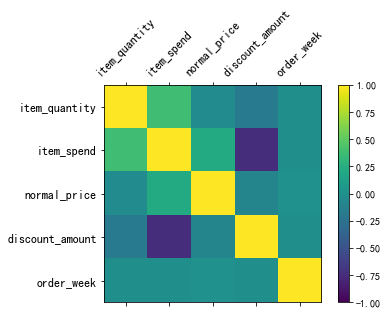

In [41]:
#相关矩阵图
names = ['item_quantity','item_spend','normal_price','discount_amount','order_week']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(item.corr(), vmin=-1,vmax=1, interpolation='none')
fig.colorbar(cax)
ticks = np.arange(0, 5, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names,rotation=45,fontsize=12)
ax.set_yticklabels(names,fontsize=12)
plt.show()

我们可以查看数据的相关性，值越接近1，说明相关性越强。也可以把相关性信息进行可视化，颜色越接近黄色相关性越高，越接近紫色相关性越低。由相关性图可知，商品销售总额与商品数量、折扣金额和商品销售总额相关性相对强，周数和销售额相关性最弱

### **6、用户分析**

**（1）用户角度分析**

In [28]:
user_grouped=item.groupby('bask_id').sum()
user_grouped.head()

,item_quantity,item_spend,normal_price,discount_amount
bask_id,,,,
100001,12.00,80.60,80.60,0.00
100002,1.41,16.02,33.50,-2.38
100003,7.00,45.30,57.40,-12.10
100004,5.00,107.80,114.90,-7.10
100005,5.11,72.60,90.20,-25.84


In [29]:
user_grouped.describe()

,item_quantity,item_spend,normal_price,discount_amount
count,280878.00,280878.00,280878.00,280878.00
mean,8.83,79.10,85.89,-10.06
std,24.48,291.24,95.76,147.36
min,0.01,0.01,0.50,-63510.60
25%,2.00,20.63,22.00,-10.16
50%,5.00,48.70,55.80,-3.00
75%,11.00,97.80,117.30,0.00
max,6581.00,80064.90,2615.90,0.00


以一个basket为一个用户，从用户角度看，每位用户平均购买8.83单位的商品，最多的用户购买了6581个商品，属于狂热用户了。用户的平均消费金额（客单价）79.1元，标准差是291.24，结合分位数和最大值看，平均值和50~75分位之间的接近，肯定存在小部分的高额消费用户。

**（2）按周维度分析**

In [33]:
#增加"orderWeek"字段，记录哪一周下单
item["order_week"] = item.shop_date.dt.weekday      #weekday周、dayofweek天、day_name

Text(0.5, 1.0, '每周销售额分析')

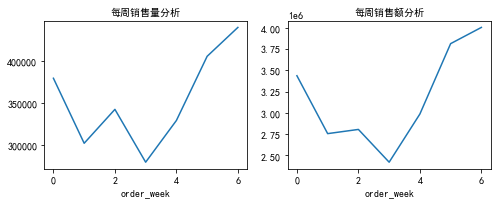

In [39]:
plt.figure(figsize=(8,6))

plt.subplot(2,2,1)
item.groupby('order_week').item_quantity.sum().plot()
plt.title("每周销售量分析",fontsize=10)

plt.subplot(2,2,2)
item.groupby('order_week').item_spend.sum().plot()
plt.title("每周销售额分析",fontsize=10)

按周统计每周的商品销量和销售额。从图中可以看到，销售量和销售额趋势相同，没有什么异常的地方，前几周销量比较平稳，甚至有些下降，而后面几周销量逐渐高涨，可能是商店逐渐被用户所认可。

**（3）观察用户消费购买力**

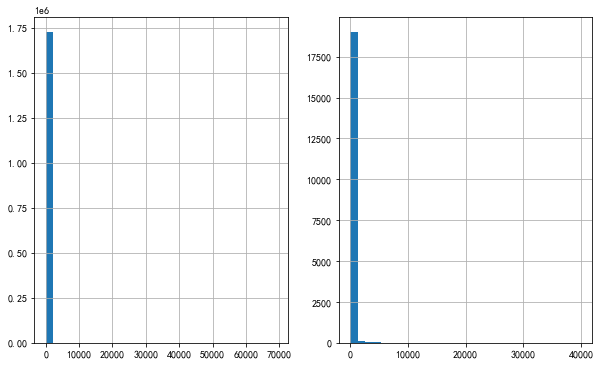

In [50]:
plt.figure(figsize=(10,6))
plt.subplot(121)
item.item_spend.hist(bins=30)

plt.subplot(122)
item.groupby('prod_id').item_quantity.sum().hist(bins=30)

左边的直方图的x轴代表item_spend的分组，一共30组。y轴代表item_spend中对应到各个分组的频数。从直方图看，大部分用户的消费能力确实不高，高消费用户在图上几乎看不到。这也确实符合消费行为的行业规律。

**（4）用户消费时间节点分析**

In [57]:
item.groupby('prod_id').shop_date.min().value_counts().head(5)

2018-06-01    7910
2018-06-02    2246
2018-06-03    1215
2018-06-04     701
2018-06-05     661
Name: shop_date, dtype: int64

In [56]:
item.groupby('prod_id').shop_date.max().value_counts().head(5)

2018-07-05    7486
2018-07-04    2257
2018-07-03    1372
2018-07-02     914
2018-07-01     834
Name: shop_date, dtype: int64

如上面所示是用户第一次消费时间和最后一次消费时间，最开始和最后的消费数量比较多，中间部分消费数量比较少，可能是由于促销原因

**（5）分析用户的复购率**

复购率 - 单位时间内，消费两次及以上的用户数 / 购买总用户数  

In [72]:
pivoted_counts=item.pivot_table(index="bask_id",columns='order_week',values='prod_id',aggfunc='count').fillna(0)
columns_day=item.order_week.sort_values().astype('str').unique()

pivoted_counts.columns=columns_day

In [73]:
#复购率
pivoted_counts_transf=pivoted_counts.applymap(lambda x:1 if x>1 else np.NAN if x==0 else 0)

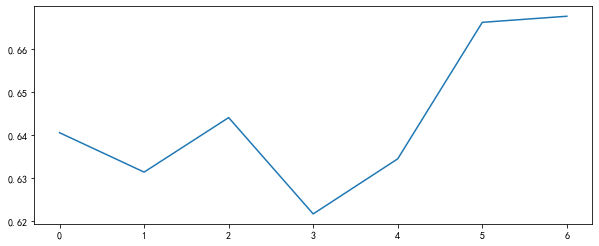

In [74]:
(pivoted_counts_transf.sum()/pivoted_counts_transf.count()).plot(figsize=(10,4))

图上复购率可知复购率一直在62%以上，可能因为是零售商店，用户会经常购买商品，尤其到最后几周复购率更高，可能因为用户信任店铺

**（6）用户RFM分析**

In [76]:
item.head()

,shop_date,store_id,pos_id,bask_id,prod_id,item_quantity,item_spend,normal_price,discount_type,discount_amount,order_week
0,2018-06-01,D007,3,250451,29405,1.00,1.70,2.00,m,-0.30,4
1,2018-06-01,D007,3,250451,13187,1.00,1.00,1.00,n,0.00,4
2,2018-06-01,D007,3,250243,196249,1.00,99.00,99.00,m,0.00,4
3,2018-06-01,D007,3,250243,199637,1.00,9.90,16.80,p,-6.90,4
4,2018-06-01,D007,1,160905,195012,3.22,18.69,5.80,n,0.00,4


In [99]:
#关键字提取
rfm=item[['bask_id','shop_date','item_spend']]

In [100]:
r = rfm.groupby('bask_id')['shop_date'].max().reset_index()
#R值构造
r['R'] = (pd.to_datetime('2018-7-5') - r['shop_date']).dt.days
r = r[['bask_id','R']]
#F值构造
item['date_label'] = item['shop_date'].astype(str).str[:10]
dup_f = item.groupby(['bask_id','date_label'])['shop_date'].count().reset_index()
f = dup_f.groupby('bask_id')['shop_date'].count().reset_index()
f.columns = ['bask_id','F']
# M 值构造:我们只需要得到每个用户总金额，再用总金额除以购买频次，就能拿到用户平均支付金额：
sum_m = item.groupby('bask_id')['item_spend'].sum().reset_index()
sum_m.columns = ['bask_id','item_spend_all']
com_m = pd.merge(sum_m,f,left_on = 'bask_id',right_on = 'bask_id',how = 'inner')
#计算用户平均支付金额
com_m['M'] = com_m['item_spend_all'] / com_m['F']
#三个指标合并
rfm = pd.merge(r,com_m,left_on = 'bask_id',right_on = 'bask_id',how = 'inner')
rfm = rfm[['bask_id','R','F','M']]
rfm['R-SCORE'] = pd.cut(rfm['R'],bins = [0,30,60,90,120,1000000],labels = [5,4,3,2,1],right = False).astype(float)
rfm['F-SCORE'] = pd.cut(rfm['F'],bins = [1,2,3,4,5,1000000],labels = [1,2,3,4,5],right = False).astype(float)
rfm['M-SCORE'] = pd.cut(rfm['M'],bins = [0,50,100,150,200,10000000],labels = [1,2,3,4,5],right = False).astype(float)
rfm['R是否大于均值'] = (rfm['R-SCORE'] > rfm['R-SCORE'].mean()) * 1
rfm['F是否大于均值'] = (rfm['F-SCORE'] > rfm['F-SCORE'].mean()) * 1
rfm['M是否大于均值'] = (rfm['M-SCORE'] > rfm['M-SCORE'].mean()) * 1
#先引入一个人群数值的辅助列，把之前判断的 R\F\M 是否大于均值的三个值给串联起来：
rfm['人群数值'] = (rfm['R是否大于均值'] * 100) + (rfm['F是否大于均值'] * 10) + (rfm['M是否大于均值'] * 1)

为了得到最终的 R 值，用今天减去每位用户最近一次付款时间，就得到 R 值了，这份订单是 7 月 5 日生成的，所以这里我们把“2018-7-5”当作“今天”：

In [94]:
def transform_label(x):
    if x == 111:
        label = '重要价值客户'
    elif x == 110:
        label = '消费潜力客户'
    elif x == 101:
        label = '频次深耕客户'
    elif x == 100:
        label = '新客户'
    elif x == 11:
        label = '重要价值流失预警客户'
    elif x == 10:
        label = '一般客户'
    elif x == 1:
        label = '高消费唤回客户'
    elif x == 0:
        label = '流失客户'
    return label

In [95]:
rfm['人群类型'] = rfm['人群数值'].apply(transform_label)
rfm.head()

,bask_id,R,F,M,R-SCORE,F-SCORE,M-SCORE,R是否大于均值,F是否大于均值,M是否大于均值,人群数值,人群类型
0,100001,24,1,80.60,5.00,1.00,2.00,1,0,1,101,频次深耕客户
1,100002,24,1,16.02,5.00,1.00,1.00,1,0,0,100,新客户
2,100003,24,1,45.30,5.00,1.00,1.00,1,0,0,100,新客户
3,100004,24,1,107.80,5.00,1.00,3.00,1,0,1,101,频次深耕客户
4,100005,24,1,72.60,5.00,1.00,2.00,1,0,1,101,频次深耕客户


In [96]:
count = rfm['人群类型'].value_counts().reset_index()
count.columns = ['客户类型','人数']
count['人数占比'] = count['人数'] / count['人数'].sum()
count

,客户类型,人数,人数占比
0,新客户,143927,0.51
1,消费潜力客户,64460,0.23
2,频次深耕客户,41827,0.15
3,重要价值客户,16323,0.06
4,流失客户,10996,0.04
5,高消费唤回客户,3273,0.01
6,一般客户,56,0.00
7,重要价值流失预警客户,16,0.00


In [97]:
rfm['购买总金额'] = rfm['F'] * rfm['M']
mon = rfm.groupby('人群类型')['购买总金额'].sum().reset_index()
mon.columns = ['客户类型','消费金额']
mon['金额占比'] = mon['消费金额'] / mon['消费金额'].sum()
mon

,客户类型,消费金额,金额占比
0,一般客户,4402.14,0.00
1,新客户,4375668.79,0.20
2,流失客户,227760.53,0.01
3,消费潜力客户,5700122.19,0.26
4,重要价值客户,4942937.89,0.22
5,重要价值流失预警客户,3602.50,0.00
6,频次深耕客户,6596386.35,0.30
7,高消费唤回客户,365743.78,0.02


In [98]:
result = pd.merge(count,mon,left_on = '客户类型',right_on = '客户类型')
result

,客户类型,人数,人数占比,消费金额,金额占比
0,新客户,143927,0.51,4375668.79,0.20
1,消费潜力客户,64460,0.23,5700122.19,0.26
2,频次深耕客户,41827,0.15,6596386.35,0.30
3,重要价值客户,16323,0.06,4942937.89,0.22
4,流失客户,10996,0.04,227760.53,0.01
5,高消费唤回客户,3273,0.01,365743.78,0.02
6,一般客户,56,0.00,4402.14,0.00
7,重要价值流失预警客户,16,0.00,3602.50,0.00
